In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -r requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 17485, done.
remote: Counting objects: 100% (127/127), done.
remote: Compressing objects: 100% (94/94), done.
remote: Total 17485 (delta 85), reused 40 (delta 33), pack-reused 17358 (from 2)
Receiving objects: 100% (17485/17485), 16.31 MiB | 29.56 MiB/s, done.
Resolving deltas: 100% (11985/11985), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/

In [ ]:
import os
import json
from PIL import Image

In [ ]:
json_dir = '/content/drive/MyDrive/dehado_data/DEHADO-AI_TRAINING_DATASET/LABELS_750'
image_dir = '/content/drive/MyDrive/dehado_data/DEHADO-AI_TRAINING_DATASET/IMAGES_750'
label_dir = '/content/drive/MyDrive/dehado_data/output_labels'
os.makedirs(label_dir, exist_ok=True)

for file in os.listdir(json_dir):
    if not file.endswith('.json'):
        continue

    json_path = os.path.join(json_dir, file)
    image_path = os.path.join(image_dir, file.replace('.json', '.jpg'))

    if not os.path.exists(image_path):
        print(f"Image {image_path} not found, skipping.")
        continue

    with open(json_path, 'r') as f:
        data = json.load(f)

    img = Image.open(image_path)
    img_w, img_h = img.size

    label_path = os.path.join(label_dir, file.replace('.json', '.txt'))
    with open(label_path, 'w') as out:
        for item in data:
            x1, y1, x2, y2 = item["Coordinate"]
            xc = (x1 + x2) / 2 / img_w
            yc = (y1 + y2) / 2 / img_h
            w = (x2 - x1) / img_w
            h = (y2 - y1) / img_h
            out.write(f"0 {xc} {yc} {w} {h}\n")  # '0' is the class ID for "handwritten"


In [ ]:
import shutil
import random

# Paths
all_images = os.listdir(image_dir)
random.shuffle(all_images)

split_idx = int(0.8 * len(all_images))
train_images = all_images[:split_idx]
val_images = all_images[split_idx:]

# Move to YOLO structure
for split, image_list in [('train', train_images), ('val', val_images)]:
    os.makedirs(f'/content/dataset/images/{split}', exist_ok=True)
    os.makedirs(f'/content/dataset/labels/{split}', exist_ok=True)
    for img_name in image_list:
        label_name = img_name.replace('.jpg', '.txt')
        shutil.copy(os.path.join(image_dir, img_name), f'/content/dataset/images/{split}/{img_name}')
        shutil.copy(os.path.join(label_dir, label_name), f'/content/dataset/labels/{split}/{label_name}')


In [ ]:
# YAML config that tells YOLO where your images and labels are
data_yaml = """
train: /content/dataset/images/train
val: /content/dataset/images/val

nc: 1
names: ['handwritten']
"""

with open('dataset.yaml', 'w') as f:
    f.write(data_yaml)


In [ ]:
# Begin training
!python train.py --img 640 --batch 16 --epochs 50 --data dataset.yaml --weights yolov5s.pt --name handwritten_detector


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2025-05-12 18:11:22.916983: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747073483.210971    5767 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747073483.284861    5767 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS wh

In [ ]:
# Run inference to test results
!python detect.py --weights runs/train/handwritten_detector/weights/best.pt \
  --img 640 --source /content/dataset/images/val --save-txt --save-conf \
  --project runs/detect --name handwritten_detect


detect: weights=['runs/train/handwritten_detector/weights/best.pt'], source=/content/dataset/images/val, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=handwritten_detect, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-418-ga493afe1 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/150 /content/dataset/images/val/MIT_101.jpg: 640x480 20 handwrittens, 28.8ms
image 2/150 /content/dataset/images/val/MIT_102.jpg: 640x480 20 handwrittens, 8.6ms
image 3/150 /content/dataset/images/val/MIT_105.jpg: 640x480 20 handwrittens, 8.6ms
image 4/150 /content/da

In [ ]:
from pathlib import Path
import json

results_dir = Path('runs/detect/handwritten_detect/labels')
output_json = {}

for txt_file in results_dir.glob('*.txt'):
    image_name = txt_file.stem
    with open(txt_file, 'r') as f:
        boxes = []
        for line in f:
            parts = line.strip().split()
            cls_id, xc, yc, w, h, conf = map(float, parts)
            boxes.append({
                "class": int(cls_id),
                "confidence": round(conf, 4),
                "x_center": xc,
                "y_center": yc,
                "width": w,
                "height": h
            })
        output_json[image_name] = boxes

with open("/content/detected_boxes.json", "w") as f:
    json.dump(output_json, f, indent=2)

print("✅ Saved: /content/detected_boxes.json")


✅ Saved: /content/detected_boxes.json


🔍 Showing: MIT_241.jpg


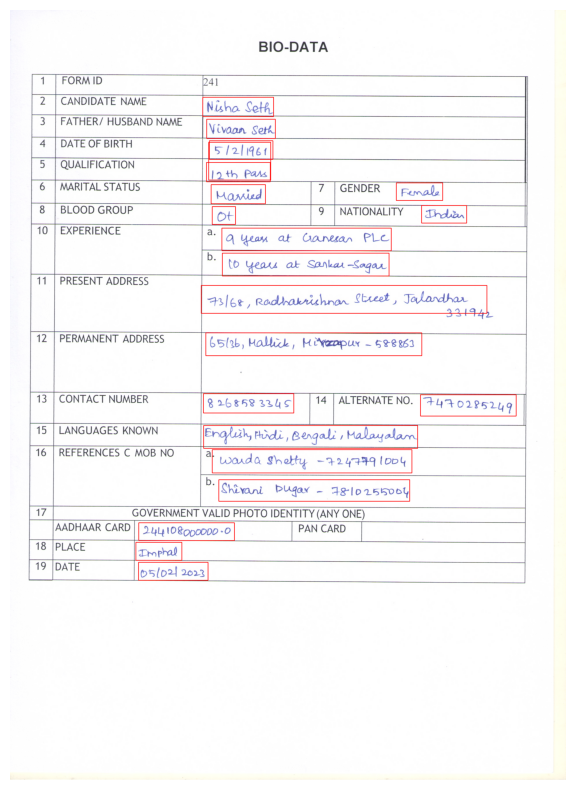

🔍 Showing: MIT_547.jpg


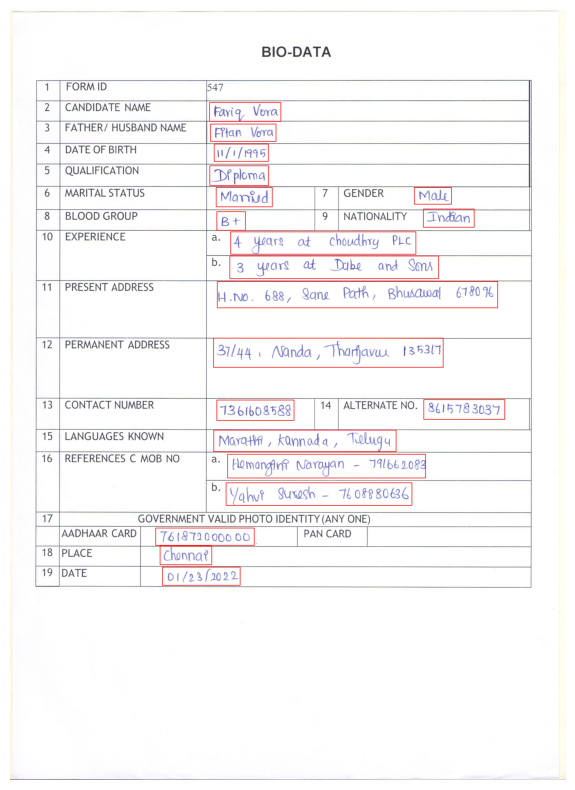

🔍 Showing: MIT_318.jpg


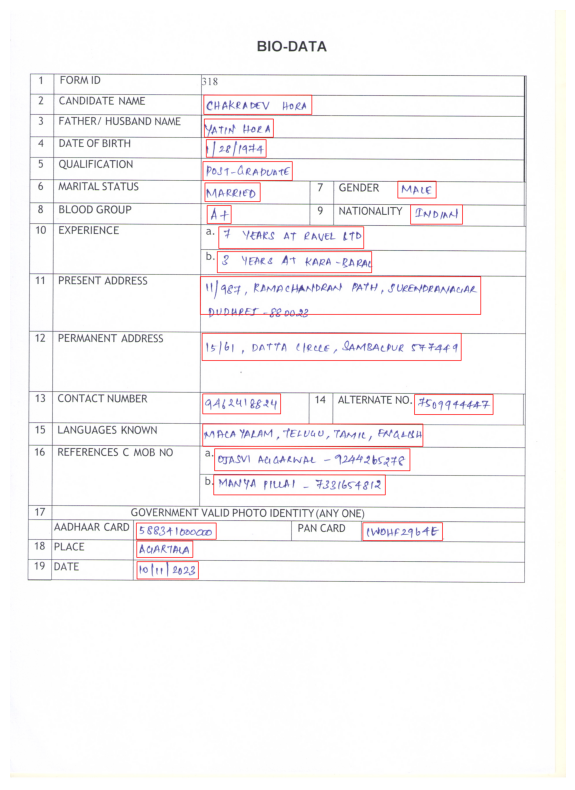

🔍 Showing: MIT_381.jpg


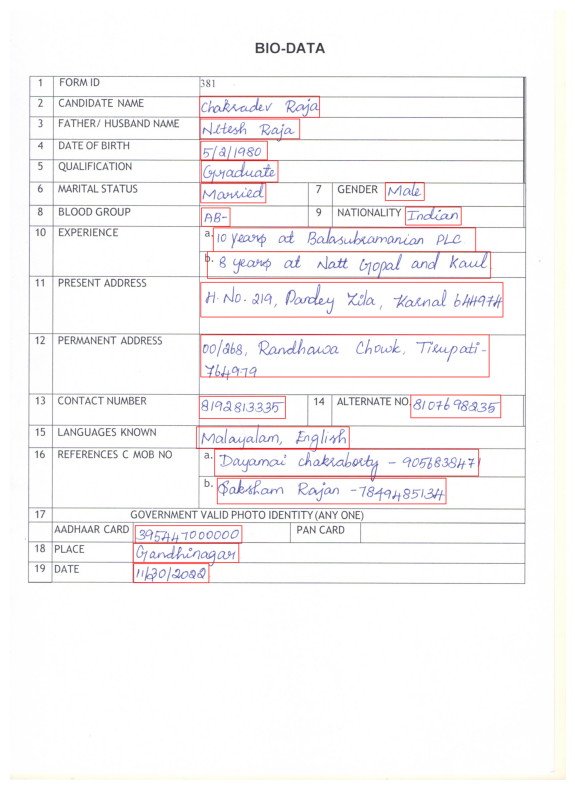

🔍 Showing: MIT_664.jpg


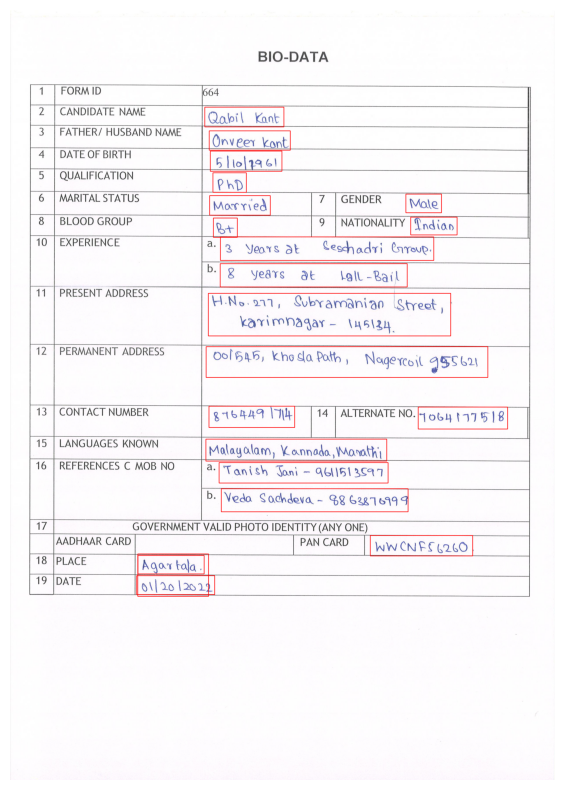

In [ ]:
import cv2
import json
import matplotlib.pyplot as plt
from pathlib import Path

# Load the JSON file with predictions
with open("/content/detected_boxes.json", "r") as f:
    predictions = json.load(f)

# Path to your original images
image_dir = Path('/content/dataset/images/val')  # adjust if needed

def draw_boxes_on_image(image_path, boxes):
    image = cv2.imread(str(image_path))
    h, w, _ = image.shape

    for box in boxes:
        xc, yc, bw, bh = box["x_center"], box["y_center"], box["width"], box["height"]
        x1 = int((xc - bw / 2) * w)
        y1 = int((yc - bh / 2) * h)
        x2 = int((xc + bw / 2) * w)
        y2 = int((yc + bh / 2) * h)

        # Draw red rectangle
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), 2)

    # Convert BGR to RGB for matplotlib display
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 10))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

# 🔁 Show first 5 detected images
count = 0
for image_name, boxes in predictions.items():
    image_path = image_dir / f"{image_name}.jpg"
    if image_path.exists():
        print(f"🔍 Showing: {image_path.name}")
        draw_boxes_on_image(image_path, boxes)
        count += 1
        if count == 5:
            break


In [ ]:
import json
import cv2
from pathlib import Path

input_json_path = "/content/detected_boxes.json"
image_dir = Path("/content/dataset/images/val")
output_json_path = "/content/detected_boxes_absolute.json"

with open(input_json_path, "r") as f:
    predictions = json.load(f)

absolute_output = {}

for image_name, boxes in predictions.items():
    img_path = image_dir / f"{image_name}.jpg"
    if not img_path.exists():
        continue

    image = cv2.imread(str(img_path))
    h, w, _ = image.shape

    abs_boxes = []
    for box in boxes:
        xc, yc, bw, bh = box["x_center"], box["y_center"], box["width"], box["height"]
        x1 = int((xc - bw / 2) * w)
        y1 = int((yc - bh / 2) * h)
        x2 = int((xc + bw / 2) * w)
        y2 = int((yc + bh / 2) * h)

        abs_boxes.append({
            "class": box["class"],
            "confidence": box["confidence"],
            "x1": x1,
            "y1": y1,
            "x2": x2,
            "y2": y2
        })

    absolute_output[image_name] = abs_boxes

# Save to JSON
with open(output_json_path, "w") as f:
    json.dump(absolute_output, f, indent=2)

print(f"✅ Saved absolute box coordinates to: {output_json_path}")


✅ Saved absolute box coordinates to: /content/detected_boxes_absolute.json
